# Выпускная классификационная работа
***
### Разработка модели машинного обучения для распознавания типов сельскохозяйственных культур, произростающих на территории Хабаровского края, на основе данных дистанционного зондирования Земли

*Датасет получен в рамках хакатона [ScienceDataLab2023](http://sciencedatalab.ccfebras.ru/).*

Для построения модели классификации будут использоваться сглаженные временные ряды вегетационного индекса *NDVI*,  рассчитанного с помощью оптических снимков, полученных со спутника Sentinel-2A.

Датасет состоит из точек, для которых известна информация о севообороте. В нем содержатся данные 11948 точек сельскохозяйственных полей Хабаровского края с указанием произрастающей культуры.

*Описание данных*:
- **Числовые столбцы** - значение индекса *NDVI* (принимает значение от -1 до 1) в день от начала года (название столбца <=> номер дня);
- **Culture** - название выращиваемой культуры.

*Список сельскохозяйственных культур*:

|Номер|Название культуры|
|-----|-----------------|
|1|залежь|
|2|соя|
|3|гречиха|
|4|пар|
|5|многолетние травы|
|6|овёс|
|7|кукуруза|
|8|капуста|
|9|картофель|
|10|пшеница|
|11|рапс|
|12|ячмень|

### Библиотеки

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import optuna as opt
import geemap
import geemap.colormaps as cm
import os
import ee
import statsmodels

from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from imblearn.over_sampling import SMOTE

%matplotlib inline
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [59]:
orig_df = pd.read_csv('data/dataset.csv')
orig_df = orig_df.drop(['n'], axis=1) # удаляем лишний столбец индекса

orig_df

,121,128,135,142,149,156,163,170,177,184,...,240,247,254,261,268,275,282,289,296,Culture
0,0.152669,0.174438,0.209893,0.256847,0.311688,0.369805,0.426172,0.475995,0.515328,0.541544,...,0.408483,0.385844,0.365548,0.346269,0.326351,0.304307,0.279290,0.251440,0.222043,рапс
1,0.084050,0.086133,0.108377,0.150274,0.207985,0.274870,0.342531,0.402199,0.446191,0.469186,...,0.205599,0.198665,0.203006,0.213593,0.224371,0.229603,0.225114,0.209236,0.183238,овёс
2,0.096446,0.126057,0.176833,0.242489,0.314037,0.381269,0.434477,0.466086,0.471930,0.451926,...,0.172827,0.199820,0.232640,0.262798,0.282596,0.286615,0.272769,0.242751,0.201755,ячмень
3,0.179056,0.218924,0.273501,0.337271,0.403364,0.464549,0.514283,0.547656,0.562066,0.557534,...,0.345934,0.347316,0.351494,0.353862,0.350224,0.337656,0.315155,0.283937,0.247342,рапс
4,0.079677,0.089905,0.117176,0.159635,0.213100,0.271661,0.328564,0.377248,0.412350,0.430514,...,0.240325,0.233890,0.234504,0.238449,0.241388,0.239296,0.229331,0.210486,0.183892,овёс
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11943,0.163391,0.143697,0.120005,0.100573,0.093871,0.106969,0.144125,0.205823,0.288415,0.384453,...,0.516079,0.413483,0.307684,0.210348,0.131209,0.076724,0.049286,0.047101,0.064746,кукуруза
11944,0.147970,0.150326,0.152982,0.160208,0.176418,0.205235,0.248674,0.306550,0.376243,0.452846,...,0.566894,0.486159,0.398266,0.311380,0.232951,0.168780,0.122368,0.094625,0.083989,кукуруза
11945,0.147232,0.170638,0.207521,0.255601,0.311228,0.369807,0.426369,0.476202,0.515442,0.541529,...,0.405568,0.382157,0.361146,0.341293,0.321003,0.298807,0.273828,0.246122,0.216851,рапс
11946,0.066331,0.067535,0.077478,0.097123,0.127420,0.168845,0.220956,0.282059,0.349084,0.417726,...,0.511493,0.452047,0.387317,0.322239,0.260995,0.206638,0.160959,0.124610,0.097426,картофель


## Добавление новых данных

Прежде чем переходить к анализу и очистке исходного датасета, можно слегка его доработать, путем введения нового класса – «лес». Под этим классом подразумеваются территории, которые не являются засеянными. Сделано это было для того, чтобы модель могла отличить засеянные сельскохозяйственными культурами территории от обычных «диких» мест.

Для того, чтобы выделить новые временные ряды NDVI, был использовал **Google Engine Earth** (платформа для анализа и визуализации наборов геопространственных данных, который располагает библиотекой для Python - *geemap*).

In [3]:
# # карта
# m = geemap.Map()

In [4]:
# # загружаем коллекцию изображений с уже рассчитанным NDVI
# collection = ee.ImageCollection('MODIS/006/MOD13A2') \
#     .filterDate('2022-04-22', '2022-11-02') \
#     .select('NDVI')
    
# image = collection.toBands()

# palette = cm.palettes.ndvi

# ndvi_vis = {
#     'min': 0.0,
#     'max': 9000.0,
#     'palette': palette
# }

# # наносим на карту слой NDVI
# m.addLayer(image, {}, 'MODIS NDVI Time-series')
# m.addLayer(image.select(0), ndvi_vis, 'MODIS NDVI VIS')

# m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
# позволяет делать метки тех мест (в нашем случае леса Хабаровского края), к-е нас интересуют
# m.set_plot_options(add_marker_cluster=True)

In [6]:
# сохраняем все отмеченные метки в файлах разных форматов, один из к-х формата csv
# out_dir = os.path.expanduser('~\data')
# out_shp = os.path.join(out_dir, 'ndvi.shp')
# m.extract_values_to_points(out_shp)

Перед тем, как объединять новые данные с исходными, необходимо:
- привести данные к нормализованному виду (т.к. в геоданных NDVI измерялся от 0 до 9000);
- заполнить пустые значения, т.к. геоданные предоставляют средние значения только за 2 недели;
- сгладить новоиспеченные временные ряды, с помощью экспоненциального сглаживания.

In [60]:
forest_ndvi = pd.read_csv('data/ndvi.csv').drop(['id', 'longitude', 'latitude'], axis=1)

# нормализация
scaler = MinMaxScaler(feature_range=(-1, 1))
forest_ndvi = scaler.fit_transform(forest_ndvi)

forest_ndvi = pd.DataFrame(forest_ndvi, columns=['121', '135', '149', '163', '177', '191', '205', '219', '233', '247', '261', '275', '289'])
nan_table = pd.DataFrame(np.full(shape=(538, 13), fill_value=np.nan), columns=['128', '142', '156', '170', '184', '198', '212', '226', '240', '254', '268', '282', '296'])
forest_ndvi = pd.concat([forest_ndvi, nan_table], axis=1)
forest_ndvi = forest_ndvi.reindex(sorted(forest_ndvi.columns), axis=1)

#интерполяция
forest_ndvi = forest_ndvi.interpolate(method='linear', limit_direction='forward', axis=1)

# сглаживание
for i, row in forest_ndvi.iterrows():
    smoother = SimpleExpSmoothing(row)
    forest_ndvi.iloc[i, :] = smoother.fit(smoothing_level=0.5, optimized=False).fittedvalues

forest_ndvi = pd.concat([forest_ndvi, pd.DataFrame(np.full(shape=(538, 1), fill_value='лес'), columns=['Culture'])], axis=1)

forest_ndvi

,121,128,135,142,149,156,163,170,177,184,...,240,247,254,261,268,275,282,289,296,Culture
0,0.064230,0.064230,0.266264,0.569315,0.710812,0.771532,0.798225,0.807906,0.816315,0.824089,...,0.699981,0.718523,0.728843,0.617861,0.446227,0.239572,0.015408,-0.095562,-0.149933,лес
1,0.127654,0.127654,0.335309,0.646791,0.797737,0.868414,0.859723,0.811347,0.808794,0.829153,...,0.663050,0.697689,0.734121,0.659010,0.528129,0.333080,0.105947,0.117858,0.249290,лес
2,0.310938,0.310938,0.476556,0.724983,0.834626,0.874876,0.847405,0.786073,0.789154,0.824442,...,0.662463,0.692200,0.733245,0.629344,0.452970,0.292870,0.140906,0.053442,-0.001772,лес
3,0.022306,0.022306,0.243207,0.574559,0.708091,0.742712,0.764625,0.780182,0.796295,0.812685,...,0.451587,0.427079,0.385811,0.295375,0.180353,0.036408,-0.122000,-0.202487,-0.244014,лес
4,-0.407686,-0.407686,-0.071514,0.432744,0.675410,0.787281,0.843578,0.872090,0.883327,0.885927,...,0.556347,0.490817,0.400117,0.305886,0.209889,0.016655,-0.225197,-0.313629,-0.325351,лес
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,0.776404,0.776404,0.700374,0.586330,0.528435,0.498616,0.545508,0.630755,0.701182,0.764200,...,0.586112,0.508814,0.385573,0.306868,0.250430,0.257747,0.296941,0.239476,0.133681,лес
534,0.562483,0.562483,0.447174,0.274211,0.342023,0.530223,0.632183,0.691023,0.737227,0.777113,...,0.622435,0.505907,0.330308,0.239188,0.190307,0.208241,0.259583,0.208811,0.106982,лес
535,0.639882,0.639882,0.515859,0.329826,0.395694,0.587512,0.663220,0.680873,0.710493,0.746096,...,0.604422,0.634769,0.662302,0.530581,0.319233,0.266309,0.292597,0.228066,0.118125,лес
536,0.800054,0.800054,0.652454,0.431054,0.432818,0.546165,0.588288,0.594799,0.624109,0.664818,...,0.460868,0.505090,0.560467,0.499464,0.380270,0.356023,0.379250,0.375194,0.357497,лес


**Итоговый датасет:**

In [61]:
df = pd.concat([orig_df, forest_ndvi], axis=0).reset_index(drop=True)

df

,121,128,135,142,149,156,163,170,177,184,...,240,247,254,261,268,275,282,289,296,Culture
0,0.152669,0.174438,0.209893,0.256847,0.311688,0.369805,0.426172,0.475995,0.515328,0.541544,...,0.408483,0.385844,0.365548,0.346269,0.326351,0.304307,0.279290,0.251440,0.222043,рапс
1,0.084050,0.086133,0.108377,0.150274,0.207985,0.274870,0.342531,0.402199,0.446191,0.469186,...,0.205599,0.198665,0.203006,0.213593,0.224371,0.229603,0.225114,0.209236,0.183238,овёс
2,0.096446,0.126057,0.176833,0.242489,0.314037,0.381269,0.434477,0.466086,0.471930,0.451926,...,0.172827,0.199820,0.232640,0.262798,0.282596,0.286615,0.272769,0.242751,0.201755,ячмень
3,0.179056,0.218924,0.273501,0.337271,0.403364,0.464549,0.514283,0.547656,0.562066,0.557534,...,0.345934,0.347316,0.351494,0.353862,0.350224,0.337656,0.315155,0.283937,0.247342,рапс
4,0.079677,0.089905,0.117176,0.159635,0.213100,0.271661,0.328564,0.377248,0.412350,0.430514,...,0.240325,0.233890,0.234504,0.238449,0.241388,0.239296,0.229331,0.210486,0.183892,овёс
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12481,0.776404,0.776404,0.700374,0.586330,0.528435,0.498616,0.545508,0.630755,0.701182,0.764200,...,0.586112,0.508814,0.385573,0.306868,0.250430,0.257747,0.296941,0.239476,0.133681,лес
12482,0.562483,0.562483,0.447174,0.274211,0.342023,0.530223,0.632183,0.691023,0.737227,0.777113,...,0.622435,0.505907,0.330308,0.239188,0.190307,0.208241,0.259583,0.208811,0.106982,лес
12483,0.639882,0.639882,0.515859,0.329826,0.395694,0.587512,0.663220,0.680873,0.710493,0.746096,...,0.604422,0.634769,0.662302,0.530581,0.319233,0.266309,0.292597,0.228066,0.118125,лес
12484,0.800054,0.800054,0.652454,0.431054,0.432818,0.546165,0.588288,0.594799,0.624109,0.664818,...,0.460868,0.505090,0.560467,0.499464,0.380270,0.356023,0.379250,0.375194,0.357497,лес


## Анализ и очистка данных

Рассмотрим, как выглядит временной ряд у каждой культуры (возьмем среднее по каждому дню).

In [65]:
# функция для визуализации временных рядов
def create_plot(df_viz, title):
    cul = list(df['Culture'].unique().tolist())

    fig, ax = plt.subplots(figsize=(10,8))

    plt.yticks(fontsize=10)

    ax.set_xlabel('Дни от начала года',fontsize = 10,fontweight="bold")
    ax.set_ylabel('Средний NDVI',fontsize = 16,fontweight="bold")
    ax.patch.set_edgecolor('black')

    ax.patch.set_linewidth(1)
    plt.ylim([0.1, 0.9])


    xx= ['121', '128', '135', '142', '149', '156', '163', '170', '177', '184', '191', '198', '205', '212', '219', '226', '233', '240', '247', '254', '261', '268', '275', '282', '289', '296']
    colors = list(plt.cm.tab10.colors)
    colors.extend(list(plt.cm.Set3.colors))
    for i in range(len(cul)):
        p = df_viz.loc[(df_viz['Culture'] == cul[i])].drop(columns=['Culture']).mean()
        ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2, color=colors[i])
    plt.yticks(size=10, fontweight="bold")
    leg = ax.legend(fontsize=9, loc ='upper right')
    ax.set_title(title)

    plt.show()

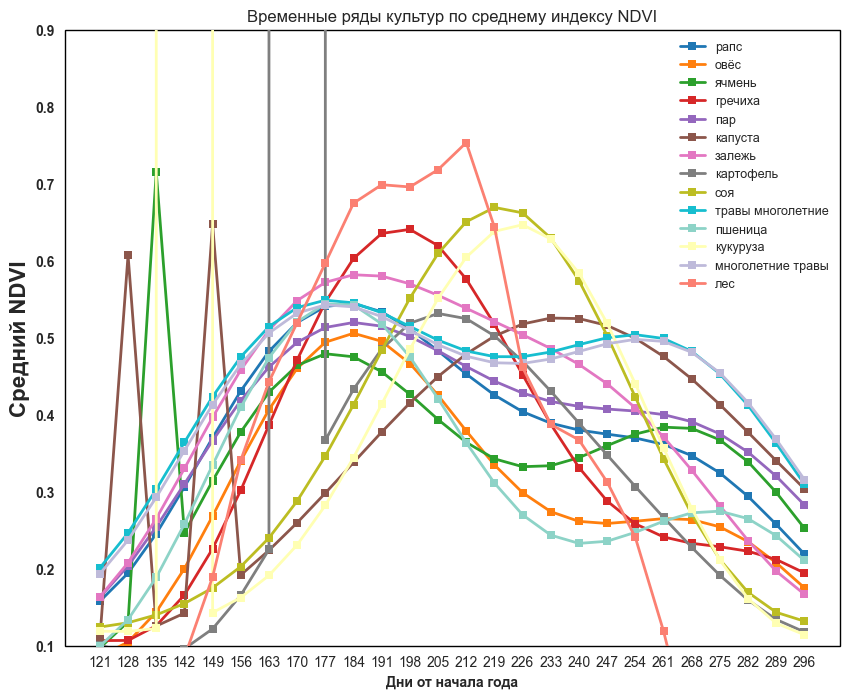

In [66]:
create_plot(df, 'Временные ряды культур по среднему индексу NDVI')

Из графика видно, что данные "сырые":
- «взрыв линий» в начале графика свидетельствует о том, что среди данных присутствуют большие показатели NDVI;
- некоторые культуры друг на друга похожи, что плохо скажется на будущей модели;
- среди изначальных 12 категорий появилась еще одна – *«травы многолетние»*. Очевидно, это часть данных *«многолетние травы»*.


In [67]:
df['Culture'].value_counts()

Culture
залежь               999
рапс                 998
гречиха              998
картофель            997
соя                  997
ячмень               996
овёс                 995
капуста              994
пар                  993
пшеница              993
кукуруза             992
многолетние травы    933
лес                  538
травы многолетние     63
Name: count, dtype: int64

Почти все культуры примерно равны по своей численности. Согласно изначальному списку, категории *«травы многолетние»* не может быть, следовательно, необходимо обратить эту категорию в *«многолетние травы»*. По итогу кол-во *«многолетних трав»* должно стать равным 996.

In [68]:
df['Culture'] = df['Culture'].apply(lambda cult: 'многолетние травы' if cult=='травы многолетние' else cult)

df['Culture'].value_counts()

Culture
залежь               999
рапс                 998
гречиха              998
картофель            997
соя                  997
ячмень               996
многолетние травы    996
овёс                 995
капуста              994
пар                  993
пшеница              993
кукуруза             992
лес                  538
Name: count, dtype: int64

Рассмотрим общую статистику.

In [69]:
df_dis = df.describe()

df_dis

,121,128,135,142,149,156,163,170,177,184,...,233,240,247,254,261,268,275,282,289,296
count,12486.000000,12478.000000,12477.000000,1.248400e+04,12481.000000,12481.000000,12482.000000,1.248300e+04,12485.000000,12486.000000,...,12486.000000,12486.000000,12486.000000,12486.000000,12486.000000,12486.000000,12486.000000,12486.000000,12486.000000,12486.000000
mean,0.124213,0.183525,0.219081,8.994045e+10,0.309385,0.327847,0.381012,2.678138e+11,0.466488,0.494968,...,0.432772,0.413037,0.391603,0.368607,0.341807,0.311548,0.282316,0.252672,0.222335,0.192998
std,0.113386,4.377977,4.744958,1.004921e+13,4.296472,0.145276,0.147118,2.992213e+13,0.132278,0.118201,...,0.155808,0.152586,0.144312,0.137879,0.137470,0.148505,0.157815,0.164118,0.153096,0.133289
min,-1.000000,-1.000000,-0.997136,-9.928411e-01,-0.857437,-0.803406,-0.852202,-9.261008e-01,-0.666695,-0.479855,...,-0.671751,-0.835875,-0.917938,-0.958969,-0.979484,-0.989742,-0.971320,-0.938557,-0.849109,-0.920738
25%,0.093017,0.101836,0.115176,1.377221e-01,0.165497,0.197474,0.249797,3.173711e-01,0.385051,0.427172,...,0.346169,0.319312,0.292242,0.272232,0.262200,0.241760,0.218818,0.191233,0.160054,0.134916
50%,0.119053,0.135310,0.170913,2.243505e-01,0.288043,0.354343,0.412827,4.629622e-01,0.499644,0.517123,...,0.437296,0.421995,0.403756,0.377153,0.346826,0.311456,0.279221,0.248391,0.219721,0.190681
75%,0.158292,0.192153,0.243028,3.018998e-01,0.366251,0.429614,0.484819,5.264198e-01,0.554560,0.569427,...,0.543445,0.521811,0.490364,0.455477,0.414841,0.384470,0.361658,0.337625,0.303922,0.263464
max,1.000000,489.000000,530.000000,1.122817e+15,480.000000,0.878212,0.919476,3.343120e+15,0.945773,0.966457,...,0.910774,0.955387,0.865586,0.923699,0.802025,0.855948,0.876780,0.861080,0.841087,0.875682


In [70]:
# NDVI лежит в диапазоне от -1 до 1, следовательно, показатели не должны выходить за диапазон
mask = (df_dis.loc['mean'] > 1) | (df_dis.loc['mean'] < -1)
df_dis.loc['mean'][mask]

142    8.994045e+10
170    2.678138e+11
Name: mean, dtype: float64

In [71]:
mask = (df_dis.loc['max'] > 1) | (df_dis.loc['max'] < -1)
df_dis.loc['max'][mask]

128    4.890000e+02
135    5.300000e+02
142    1.122817e+15
149    4.800000e+02
170    3.343120e+15
Name: max, dtype: float64

В данных содержатся аномальные значения, которые выбиваются из стандартного диапазона NDVI. Нужно заменить такие значения на пустые и задача превращается уже в обработку пустых значений.

In [72]:
# датасет без таргета
df_ts = df.iloc[:, :-1]

for column in df_ts.columns:
    df_ts[column] = df_ts[column].apply(lambda x: np.nan if x < -1 or x > 1 else x)

Рассмотрим, какие столбцы имеют пустые значения и какой процент эти значения занимают.

In [73]:
cols_null_percent = df_ts.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
round(cols_with_null, 2)

135    0.08
128    0.07
149    0.05
156    0.04
163    0.03
170    0.03
142    0.02
177    0.01
dtype: float64

Пустые значения занимают очень малый процент. Обрабатываться они также будут с помощью линейной интерполяции.

In [74]:
df.iloc[:, :-1] = df_ts.interpolate(method='linear', limit_direction='forward', axis=1)

# проверка на пустые значения в данных
df[df.isnull().any(axis=1)]

,121,128,135,142,149,156,163,170,177,184,...,240,247,254,261,268,275,282,289,296,Culture


Последним этапом в очистке данных будет являться удаление дубликатов.

In [75]:
df = df.drop_duplicates().reset_index(drop=True)

In [76]:
df.describe()

,121,128,135,142,149,156,163,170,177,184,...,233,240,247,254,261,268,275,282,289,296
count,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,...,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000,10177.000000
mean,0.123686,0.144293,0.177151,0.219706,0.273445,0.331949,0.386062,0.433378,0.472270,0.500884,...,0.431732,0.411176,0.388543,0.364155,0.335507,0.303263,0.273079,0.243185,0.213019,0.184265
std,0.124150,0.131063,0.136293,0.149498,0.148657,0.148766,0.149414,0.144683,0.132595,0.117912,...,0.163097,0.159363,0.150186,0.143208,0.142922,0.155624,0.166420,0.174079,0.162214,0.140615
min,-1.000000,-1.000000,-0.997136,-0.992841,-0.857437,-0.803406,-0.852202,-0.926101,-0.666695,-0.479855,...,-0.671751,-0.835875,-0.917938,-0.958969,-0.979484,-0.989742,-0.971320,-0.938557,-0.849109,-0.920738
25%,0.091731,0.101587,0.116614,0.140097,0.169032,0.205639,0.260291,0.329620,0.395436,0.435341,...,0.333039,0.310409,0.282874,0.265070,0.257640,0.238348,0.214322,0.184539,0.153059,0.130225
50%,0.118804,0.136169,0.172827,0.227271,0.291829,0.358009,0.417053,0.465931,0.500961,0.518912,...,0.438353,0.424254,0.405411,0.375921,0.340780,0.301872,0.269220,0.238827,0.210176,0.180062
75%,0.159367,0.194166,0.245306,0.303726,0.367720,0.432087,0.488671,0.529569,0.557415,0.571694,...,0.547481,0.521859,0.488072,0.451069,0.407704,0.372320,0.348097,0.325204,0.293020,0.252997
max,1.000000,1.000000,0.944548,0.913775,0.863734,0.878212,0.919476,0.926969,0.945773,0.966457,...,0.910774,0.955387,0.865586,0.923699,0.802025,0.855948,0.876780,0.861080,0.841087,0.875682


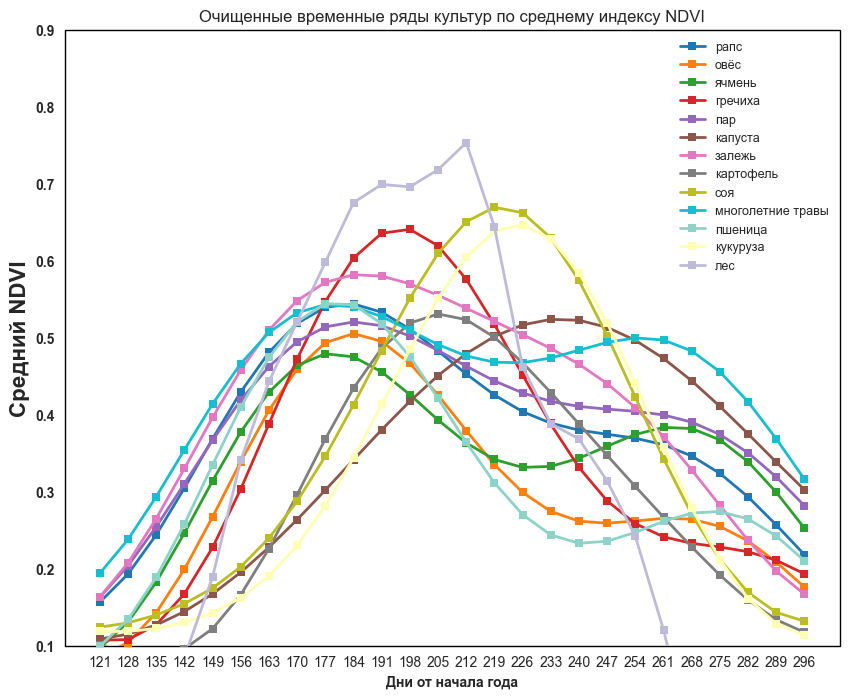

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10177 entries, 0 to 10176
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   121      10177 non-null  float64
 1   128      10177 non-null  float64
 2   135      10177 non-null  float64
 3   142      10177 non-null  float64
 4   149      10177 non-null  float64
 5   156      10177 non-null  float64
 6   163      10177 non-null  float64
 7   170      10177 non-null  float64
 8   177      10177 non-null  float64
 9   184      10177 non-null  float64
 10  191      10177 non-null  float64
 11  198      10177 non-null  float64
 12  205      10177 non-null  float64
 13  212      10177 non-null  float64
 14  219      10177 non-null  float64
 15  226      10177 non-null  float64
 16  233      10177 non-null  float64
 17  240      10177 non-null  float64
 18  247      10177 non-null  float64
 19  254      10177 non-null  float64
 20  261      10177 non-null  float64
 21  268      101

None

In [77]:
create_plot(df, 'Очищенные временные ряды культур по среднему индексу NDVI')
display(df.info())

Данные очищены и готовы для подачи в модель.

## Подготовка данных

Рассмотрим, соотношение классов в целевом признаке.

In [22]:
df['Culture'].value_counts(normalize=True)*100

Culture
соя                  9.708165
залежь               9.570600
овёс                 9.108775
ячмень               8.813992
многолетние травы    8.784514
пшеница              8.450427
кукуруза             8.155645
картофель            8.057384
пар                  7.683993
гречиха              7.202515
лес                  5.266778
рапс                 5.129213
капуста              4.067996
Name: proportion, dtype: float64

Наблюдается дисбаланс выборки. Необходимо:
- стратифицированное разбираение;
- взвешивание классов внутри моделей.

In [23]:
X = df.drop(columns=['Culture'])
y = df['Culture']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

В качестве моделей будут использоваться алгоритмы:
- **LogisticRegression с полиномом 3 степени**;
- **RandomForest**;
- **LightGBM**.

## LogisticRegression

Обучим LogisticRegression с полиномом 3 степени без регуляризации.

In [25]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr = LogisticRegression(
    penalty=None,
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr.fit(X_train_poly, y_train)

y_lr_pred = lr.predict(X_test_poly)

## RandomForest

Для того, чтобы подбирать гиперпараметры остальных моделей, был использован специальный фреймворк **Optuna**. В нем реализовано несколько алгоритмов оптимизации, самый популярный из к-х метод байесовской оптимизации - [Tree of Parzen Estimators (TPE)](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf).

На начальном этапе необходимо определить функцию, к-я строится по следующему принципу:
- формируется пространство поиска параметров с помощью аргумента *trial*;
- проводится кросс-валидация модели с заданными гиперпараметрами;
- функция возвращает результат кросс-валидации.

Наша целевая метрика: **F1-macro** (средний F1 по всем классам).

Функция подается в оптимизатор, где гиперпараметры подбираются таким образом, чтобы возращаемое(-ые) функцией значение(-ия) было максимальным (минимальным).

In [26]:
def opt_forest(trial):
    
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 10, 30, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, step=1)
    
    model = RandomForestClassifier(
        n_estimators=500,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced', # взвешивание классов
        n_jobs=-1,
        random_state=42
    )
    
    score = cross_val_score(
        model, X_train, y_train,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1
    ).mean()
    
    return score

In [27]:
forest_study = opt.create_study(study_name='RandomForest', direction='maximize')
forest_study.optimize(opt_forest, n_trials=20, n_jobs=-1)
print('Best params:', forest_study.best_params)

[I 2024-04-22 01:56:29,858] A new study created in memory with name: RandomForest
[I 2024-04-22 01:57:43,763] Trial 1 finished with value: 0.878169262591569 and parameters: {'criterion': 'log_loss', 'max_depth': 30, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.878169262591569.
[I 2024-04-22 01:58:17,744] Trial 5 finished with value: 0.8854160347544104 and parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.8854160347544104.
[I 2024-04-22 01:58:55,003] Trial 2 finished with value: 0.878169262591569 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 5 with value: 0.8854160347544104.
[I 2024-04-22 01:58:55,229] Trial 7 finished with value: 0.8888759875140941 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8888759875140941.
[I 2024-04-22 01:59:20,214] Trial 8 finished with value: 0.8898106121846965 and parameters: {'cri

Best params: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_leaf': 2}


In [28]:
forest = RandomForestClassifier(
    **forest_study.best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

forest.fit(X_train, y_train)

y_forest_pred = forest.predict(X_test)

## LightGBM

In [29]:
def opt_lgbm(trial):
    
    num_leaves = trial.suggest_int('num_leaves', 20, 200, step=5)
    max_depth = trial.suggest_int('max_depth', 3, 20, step=1)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 10, step=1)
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)
    
    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        objective='multiclass',
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    
    score = cross_val_score(
        model, X_train, y_train,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1
    ).mean()
    
    return score

In [30]:
lgbm_study = opt.create_study(study_name='LightGBM', direction='maximize')
lgbm_study.optimize(opt_lgbm, n_trials=20, n_jobs=-1)
print('Best params:', lgbm_study.best_params)

[I 2024-04-22 02:01:17,958] A new study created in memory with name: LightGBM
[I 2024-04-22 02:01:53,195] Trial 0 finished with value: 0.8908897214487441 and parameters: {'num_leaves': 170, 'max_depth': 17, 'min_child_samples': 1, 'n_estimators': 250}. Best is trial 0 with value: 0.8908897214487441.
[I 2024-04-22 02:02:01,762] Trial 1 finished with value: 0.9018691312996255 and parameters: {'num_leaves': 135, 'max_depth': 13, 'min_child_samples': 7, 'n_estimators': 230}. Best is trial 1 with value: 0.9018691312996255.
[I 2024-04-22 02:03:06,806] Trial 6 finished with value: 0.8950290515606426 and parameters: {'num_leaves': 160, 'max_depth': 15, 'min_child_samples': 2, 'n_estimators': 210}. Best is trial 1 with value: 0.9018691312996255.
[I 2024-04-22 02:03:35,866] Trial 3 finished with value: 0.8916811458829048 and parameters: {'num_leaves': 180, 'max_depth': 20, 'min_child_samples': 1, 'n_estimators': 160}. Best is trial 1 with value: 0.9018691312996255.
[I 2024-04-22 02:03:38,586] Tr

Best params: {'num_leaves': 50, 'max_depth': 14, 'min_child_samples': 10, 'n_estimators': 110}


In [ ]:
lgbm = LGBMClassifier(
    **lgbm_study.best_params,
    objective='multiclass',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

y_lgbm_pred = lgbm.predict(X_test)

## Результаты

In [32]:
# LogisticRegression
print(classification_report(y_test, y_lr_pred))

                   precision    recall  f1-score   support

          гречиха       0.96      0.91      0.93       147
           залежь       0.77      0.84      0.80       195
          капуста       0.90      0.96      0.93        83
        картофель       0.84      0.87      0.86       164
         кукуруза       0.84      0.89      0.86       166
              лес       1.00      0.96      0.98       107
многолетние травы       0.89      0.72      0.79       179
             овёс       0.83      0.76      0.79       186
              пар       0.83      0.92      0.87       156
          пшеница       0.81      0.85      0.83       172
             рапс       0.81      0.92      0.86       104
              соя       0.87      0.81      0.84       198
           ячмень       0.94      0.93      0.93       179

         accuracy                           0.86      2036
        macro avg       0.87      0.87      0.87      2036
     weighted avg       0.86      0.86      0.86      

In [33]:
# RandomForest
print(classification_report(y_test, y_forest_pred))

                   precision    recall  f1-score   support

          гречиха       0.94      0.92      0.93       147
           залежь       0.79      0.89      0.84       195
          капуста       0.95      0.98      0.96        83
        картофель       0.91      0.88      0.90       164
         кукуруза       0.89      0.91      0.90       166
              лес       0.99      0.99      0.99       107
многолетние травы       0.90      0.84      0.87       179
             овёс       0.87      0.82      0.84       186
              пар       0.89      0.90      0.89       156
          пшеница       0.86      0.84      0.85       172
             рапс       0.86      0.94      0.90       104
              соя       0.89      0.87      0.88       198
           ячмень       0.96      0.94      0.95       179

         accuracy                           0.89      2036
        macro avg       0.90      0.90      0.90      2036
     weighted avg       0.89      0.89      0.89      

In [34]:
# LightGBM
print(classification_report(y_test, y_lgbm_pred))

                   precision    recall  f1-score   support

          гречиха       0.96      0.91      0.93       147
           залежь       0.81      0.90      0.85       195
          капуста       0.95      0.96      0.96        83
        картофель       0.91      0.90      0.90       164
         кукуруза       0.92      0.95      0.93       166
              лес       1.00      0.99      1.00       107
многолетние травы       0.91      0.85      0.88       179
             овёс       0.87      0.84      0.85       186
              пар       0.92      0.92      0.92       156
          пшеница       0.87      0.88      0.87       172
             рапс       0.90      0.96      0.93       104
              соя       0.90      0.88      0.89       198
           ячмень       0.98      0.93      0.95       179

         accuracy                           0.91      2036
        macro avg       0.91      0.91      0.91      2036
     weighted avg       0.91      0.91      0.91      

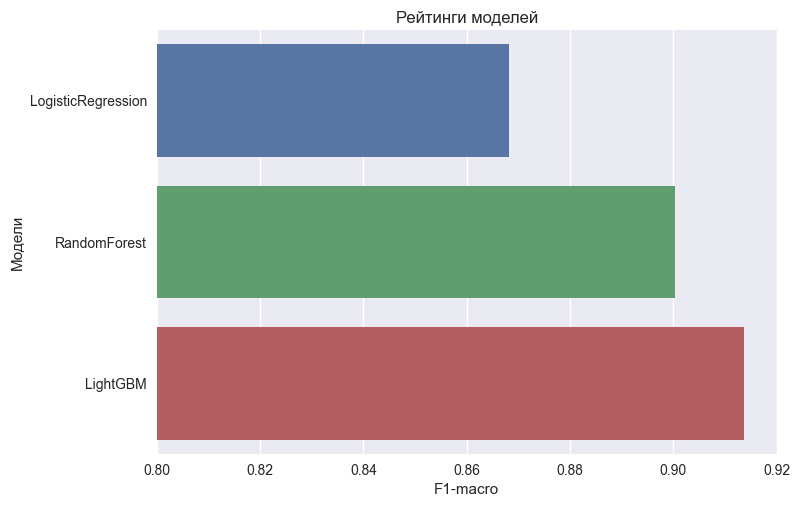

In [55]:
ratings = pd.DataFrame({'LogisticRegression': [f1_score(y_test, y_lr_pred, average='macro')],
                        'RandomForest': [f1_score(y_test, y_forest_pred, average='macro')],
                        'LightGBM': [f1_score(y_test, y_lgbm_pred, average='macro')]})

sns.barplot(ratings, orient='h')
plt.title('Рейтинги моделей')
plt.xlabel('F1-macro')
plt.ylabel('Модели')
plt.xlim(0.8, 0.92)
plt.style.use('seaborn-v0_8')

**LightGBM** обогнала всех своих конкурентов не только по целевой метрике, но и по всем остальным. Результат модели **~0.91**, что является очень хорошим показателем.

Хуже всего модель определяла классы *залежь* и *овёс* (~0.85). Лучше всего: *капуста* (~0.96) и *ячмень* (~0.95). Практически идеально определяет класс *лес* (~1.0).